In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
import argparse
import sys
import pandas as pd

from source.latent_module import Rep_AE, LatentCond_Unet, RepDDPM
from source.DDPM import Diffusion
from source.SemiSup_module import top_model, SemiSup_DDPM
import source.helper_func as hf


import logging
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
from torchvision import transforms as T
import math


In [2]:
# check GPU
if torch.cuda.is_available():
    print('GPU available')

else:
    print('Please enable GPU and rerun script')
    quit()


USE_CUDA = True
DEVICE = 'cuda' if USE_CUDA else 'cpu'


GPU available


In [3]:
def set_seed(SEED: int):

    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

set_seed(SEED = 42)

In [4]:

def prepare_data(
        batch_size: int = 32
    ):

    transforms = T.Compose(
            [
                T.Resize([32,32]),
                T.ToTensor(),
                T.Normalize((0.5), (0.5))
            ]
    )

    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

    train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size)


    return train_dataloader, mnist_trainset, test_dataloader, mnist_testset


train_dataloader, train_dataset, test_dataloader, test_dataset = prepare_data(batch_size = 32)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



C:\Users\npral\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
def get_model(
    DEVICE = DEVICE
    ):
    
    img_size = 32
    c_in = 1
    c_out = c_in
    first_num_channel = 64
    time_dim = 256
    num_layers = 3
    bn_layers = 2
    disc_num_layers = 2
    disc_width = 1000
    z_dim = 10
    
    # prefactor loss
    xi, alpha, beta, gamma = 1, 0.99, 10, 10
    
    # configure model
    rep_AE = Rep_AE(
            img_size = img_size,
            c_in = c_in,
            c_out = c_out,
            first_num_channel = first_num_channel,
            z_dim = z_dim,
            time_dim = time_dim,
            num_layers = num_layers,
            bn_layers = bn_layers
    ).to(DEVICE)

    tm_disc = top_model(
            num_layers = disc_num_layers,
            hidden_width = disc_width,
            z_dim = z_dim,
            num_classes = 10
    ).to(DEVICE)

    Unet = LatentCond_Unet(
            c_in = c_in + c_in,
            c_out = c_out,
            first_num_channel = first_num_channel,
            time_dim = time_dim,
            num_layers = num_layers,
            bn_layers = bn_layers
    ).to(DEVICE)


    diffusion = Diffusion(
            img_size = img_size,
            device =  DEVICE,
            schedule = 'linear'
    )

    model = SemiSup_DDPM(
            Unet = Unet,
            latent_AE = rep_AE,
            top_model = tm_disc,
            diffusion = diffusion,
            xi = xi,
            alpha = alpha,
            beta = beta,
            gamma = gamma
    ).to(DEVICE)


    
    return model

In [6]:
model = get_model(DEVICE = DEVICE)

In [10]:
model.load_state_dict(torch.load('./output/SSlatentDDPM/mnist/model_pretrained_weights.pth'))

<All keys matched successfully>

## Inference:

In [11]:
# start with empty tensors:
z_train = torch.zeros((60000, 10))
z_test = torch.zeros((10000,10))

In [12]:
y_train = torch.zeros((60000, 1))
y_test = torch.zeros((10000, 1))


#### Infer latent codes from the training set:

In [13]:
model.eval()

with torch.no_grad():
    
    for iteration, train_batch in tqdm(enumerate(train_dataloader)):
        
        left_idx = iteration * train_batch[0].shape[0]
        right_idx = (iteration+1) * train_batch[0].shape[0]
        
        
        train_X0 = train_batch[0].to(DEVICE)
        y_train[left_idx:right_idx, 0] = train_batch[1]
        
        t0 = (torch.ones(train_X0.shape[0]) * 0).long().to(DEVICE)
        
        _, z, z_mean, z_var = model.latent_AE(train_X0, t0)
        
        
        z_train[left_idx:right_idx, :]  = z.cpu()

0it [00:00, ?it/s]C:\Users\npral\anaconda3\envs\torch_gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
1875it [01:28, 21.17it/s]


#### Infer latent codes from the testing set:

In [14]:
model.eval()

with torch.no_grad():
    
    for iteration, test_batch in tqdm(enumerate(test_dataloader)):
        
        left_idx = iteration * test_batch[0].shape[0]
        right_idx = (iteration+1) * test_batch[0].shape[0]
        
        test_X0 = test_batch[0].to(DEVICE)
        y_test[left_idx:right_idx, 0] = test_batch[1]
        
        t0 = (torch.ones(test_X0.shape[0]) * 0).long().to(DEVICE)
        
        _, z, z_mean, z_var = model.latent_AE(test_X0, t0)
        
        
        z_test[left_idx:right_idx, :]  = z.cpu()

313it [00:14, 21.52it/s]


## Inference:

#### Training latent space:

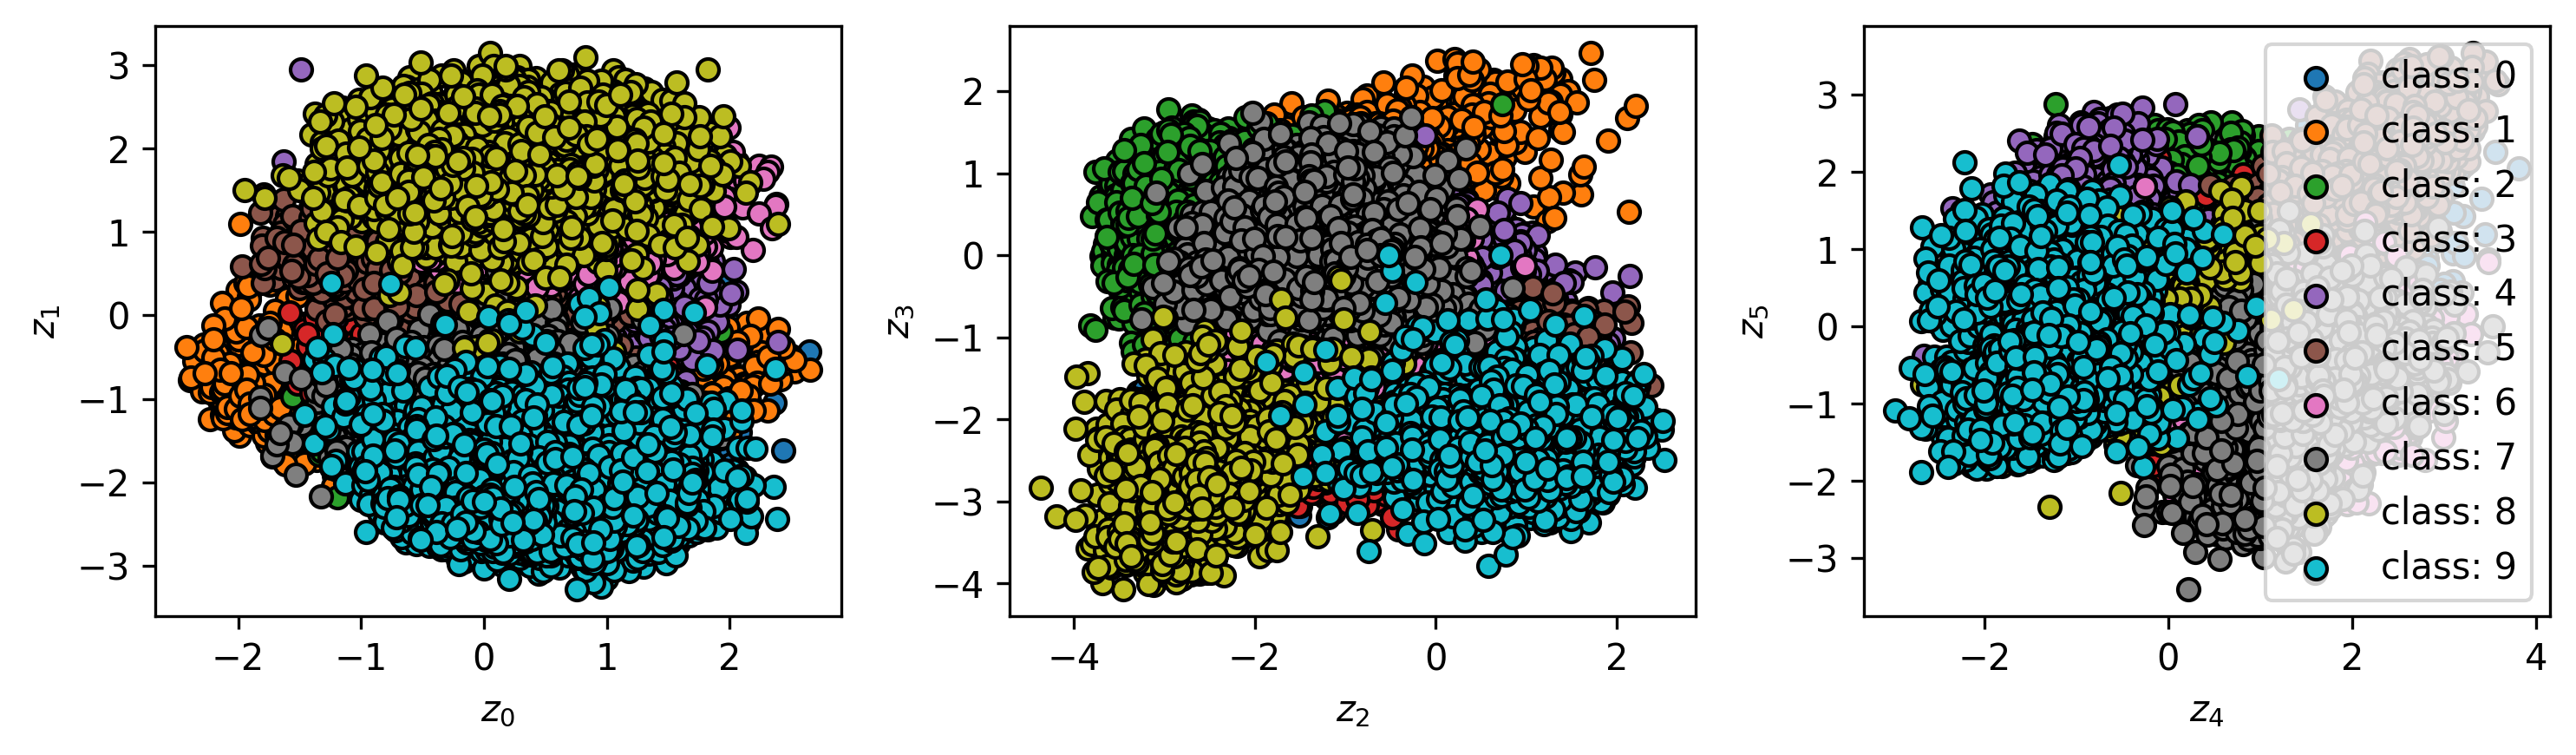

In [17]:
fig, axes = plt.subplots(1, 3, dpi = 300, figsize = (10, 3))


for label in range(10):
    y_idx = (y_train == label)[:,0]

    axes[0].scatter(z_train[y_idx,0], z_train[y_idx,1], label = f'class: {str(label)}',  edgecolor = 'k')
    axes[1].scatter(z_train[y_idx,2], z_train[y_idx,3],  label = f'class: {str(label)}', edgecolor = 'k')
    axes[2].scatter(z_train[y_idx,4], z_train[y_idx,5],  label = f'class: {str(label)}', edgecolor = 'k')

axes[0].set_xlabel('$z_0$')
axes[1].set_xlabel('$z_2$')
axes[2].set_xlabel('$z_4$')

axes[0].set_ylabel('$z_1$')
axes[1].set_ylabel('$z_3$')
axes[2].set_ylabel('$z_5$')

plt.legend()
plt.tight_layout()

plt.savefig('./output/figures/MNIST_latentspace_first2dims.png', dpi = 300)


#### Testing latent space:

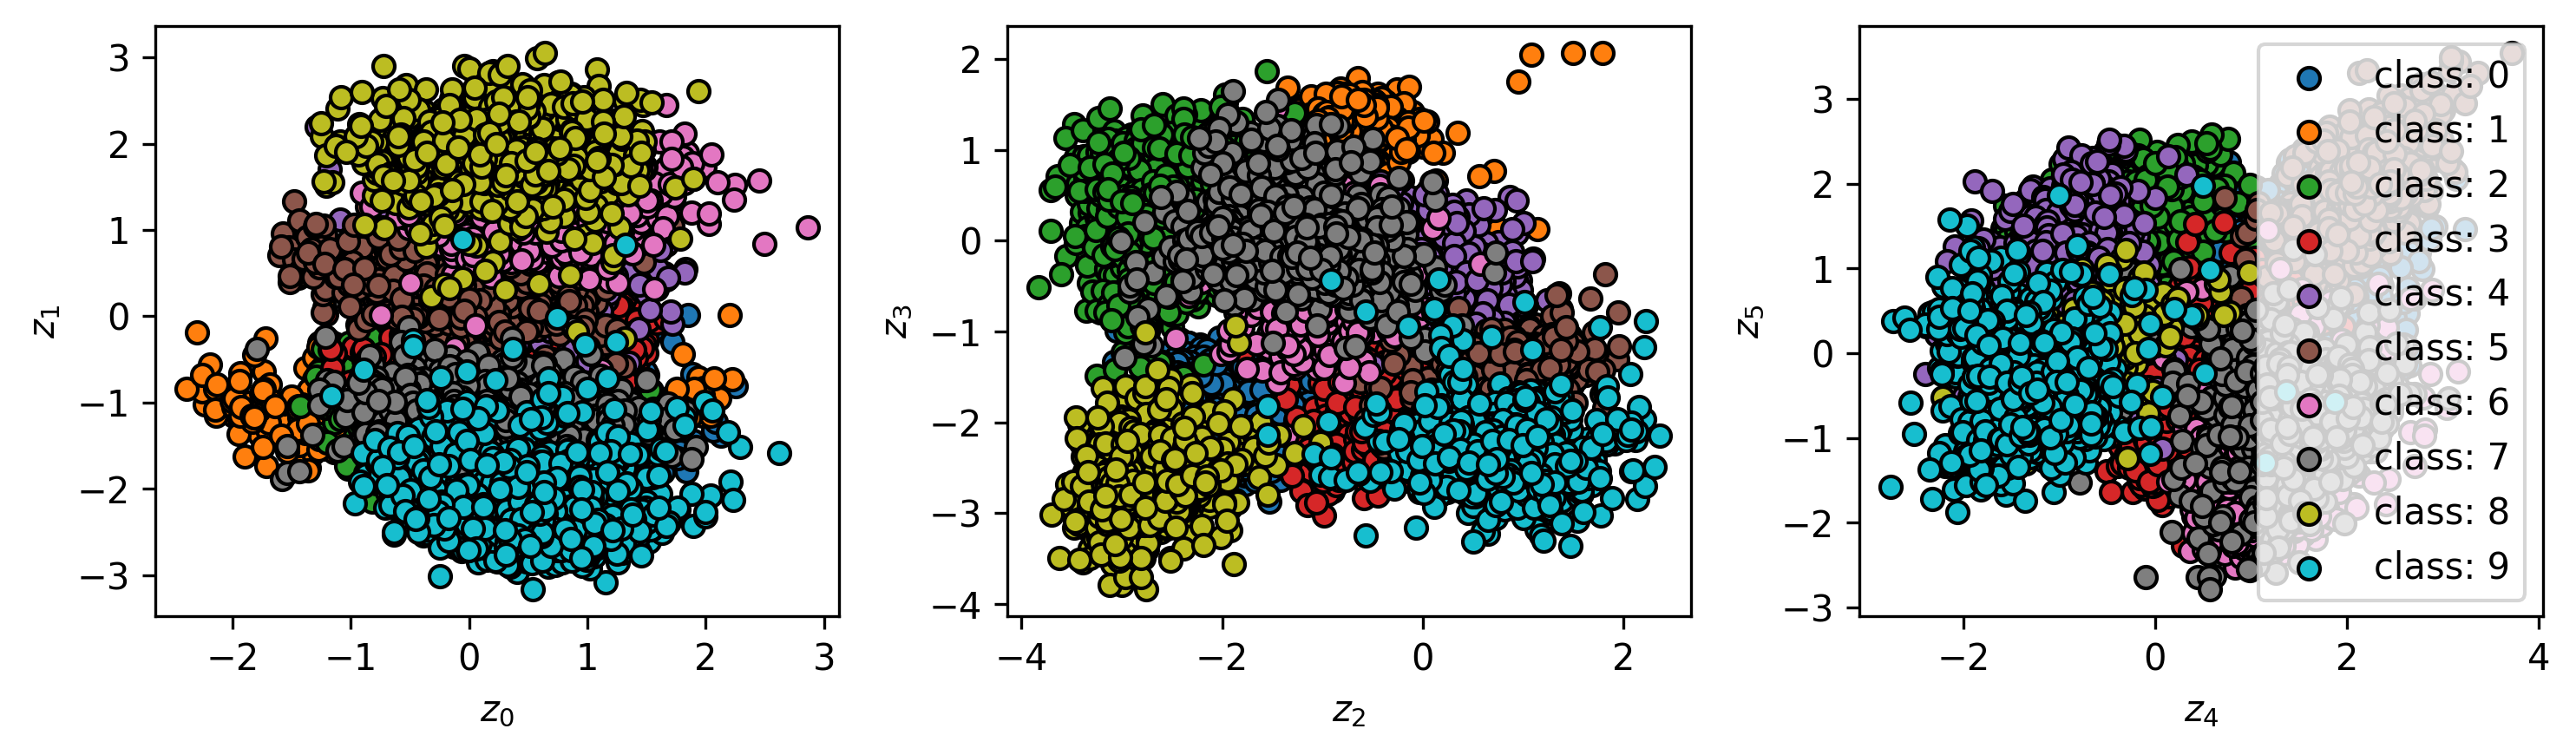

In [18]:
fig, axes = plt.subplots(1, 3, dpi = 300, figsize = (10, 3))


for label in range(10):
    y_idx = (y_test == label)[:,0]

    axes[0].scatter(z_test[y_idx,0], z_test[y_idx,1], label = f'class: {str(label)}',  edgecolor = 'k')
    axes[1].scatter(z_test[y_idx,2], z_test[y_idx,3],  label = f'class: {str(label)}', edgecolor = 'k')
    axes[2].scatter(z_test[y_idx,4], z_test[y_idx,5],  label = f'class: {str(label)}', edgecolor = 'k')

axes[0].set_xlabel('$z_0$')
axes[1].set_xlabel('$z_2$')
axes[2].set_xlabel('$z_4$')

axes[0].set_ylabel('$z_1$')
axes[1].set_ylabel('$z_3$')
axes[2].set_ylabel('$z_5$')

plt.legend()
plt.tight_layout()

plt.savefig('./output/figures/MNIST_test_latentspace_first2dims.png', dpi = 300)


## PCA embedding of the latent space:

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(z_train)

PCA(n_components=2)

#### Training and testing set PCA space:

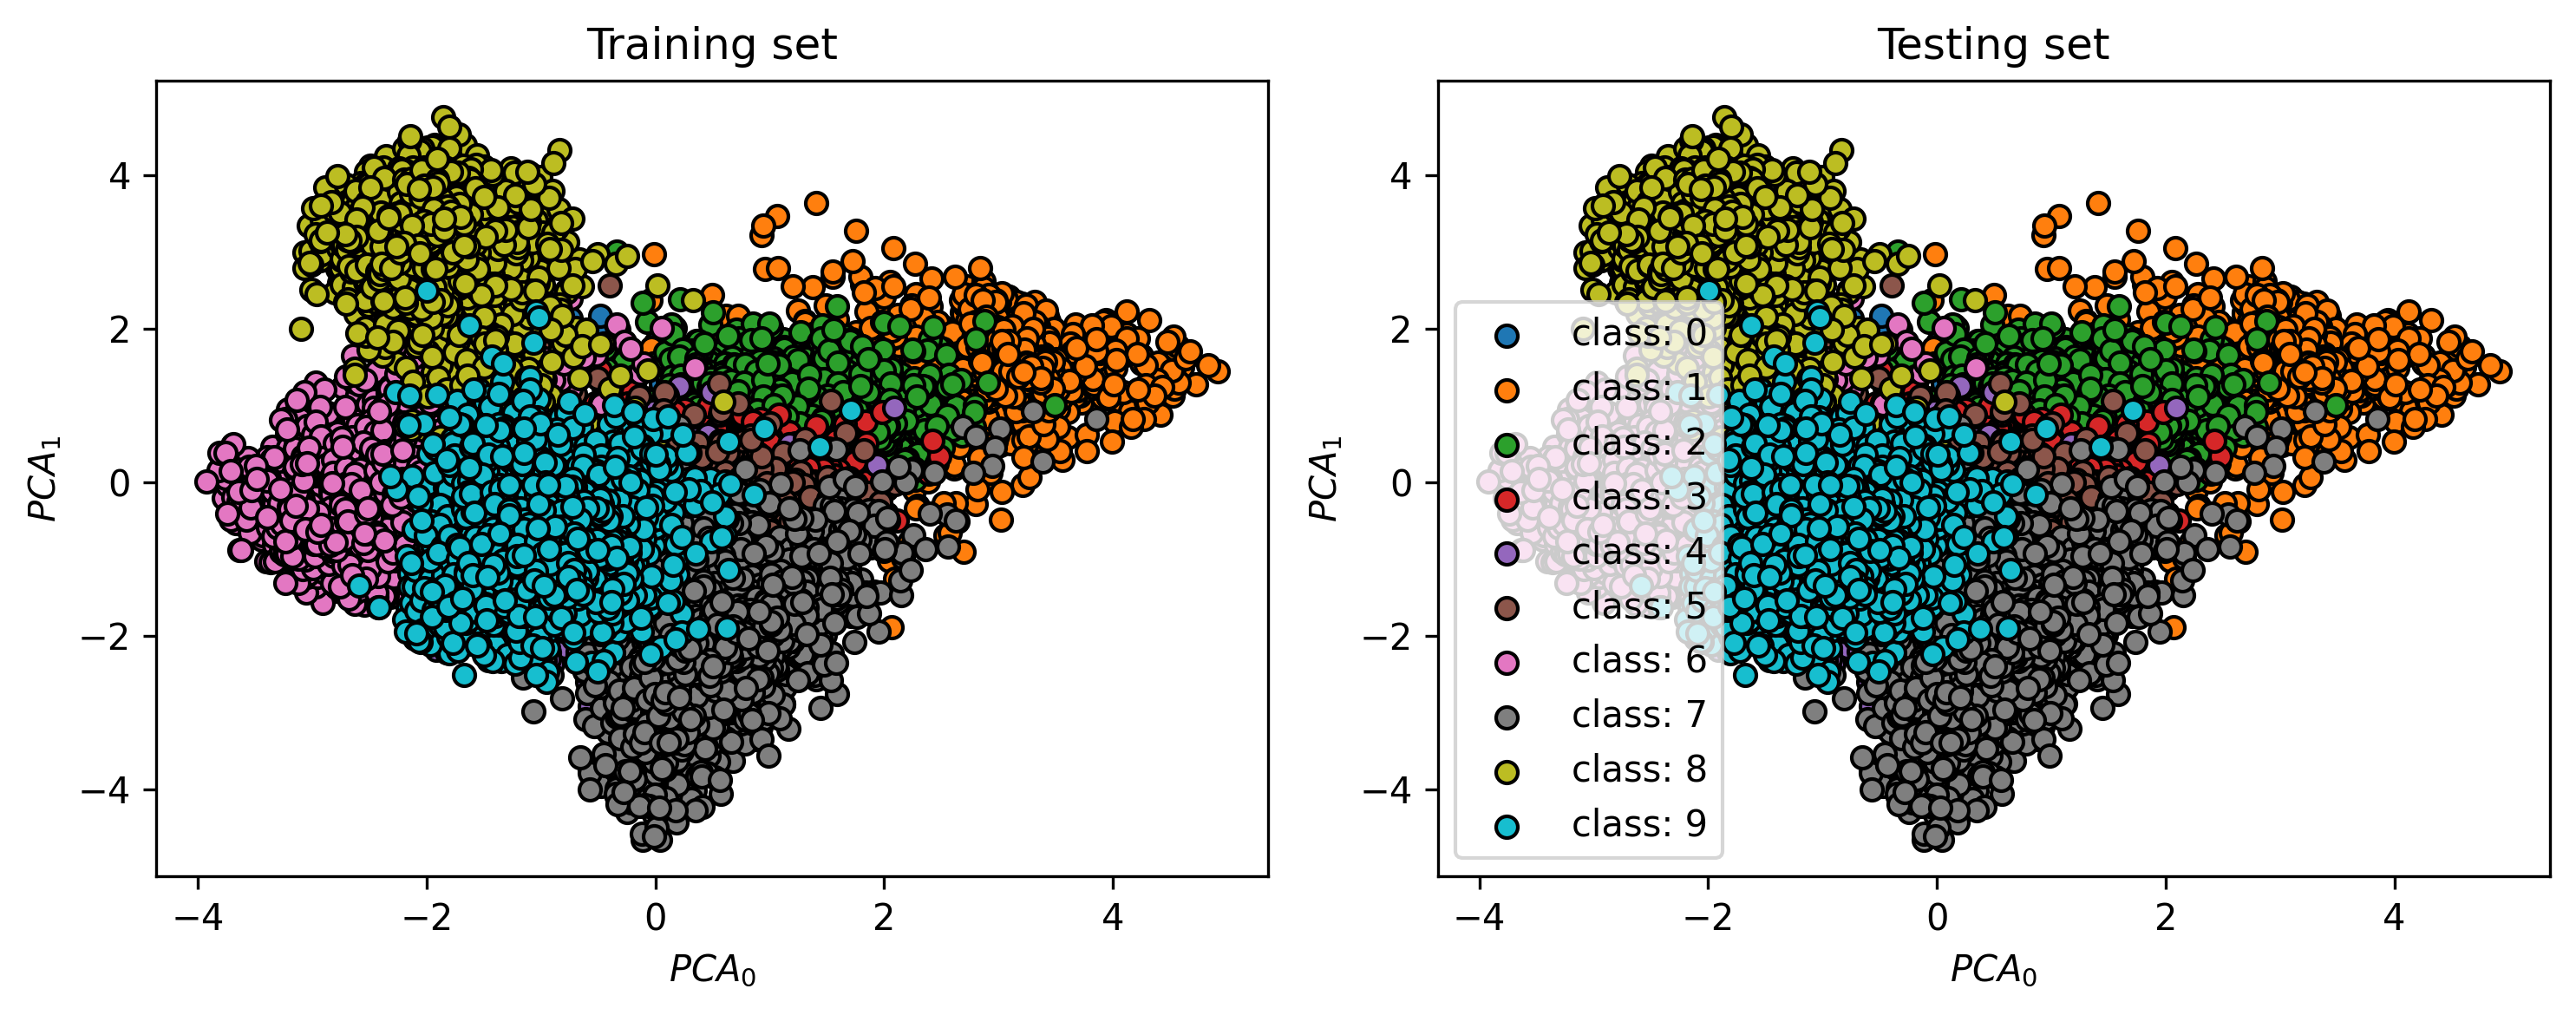

In [22]:
pca_train = pca.transform(z_train)
pca_test = pca.transform(z_test)

fig, axes = plt.subplots(1, 2, dpi = 300, figsize = (10, 4))

for label in range(10):
    y_idx = (y_train == label)[:,0]

    axes[0].scatter(pca_train[y_idx,0], pca_train[y_idx,1], label = f'class: {str(label)}',  edgecolor = 'k')
    axes[1].scatter(pca_train[y_idx,0], pca_train[y_idx,1],  label = f'class: {str(label)}', edgecolor = 'k')

axes[0].set_xlabel('$PCA_0$')
axes[1].set_xlabel('$PCA_0$')

axes[0].set_ylabel('$PCA_1$')
axes[1].set_ylabel('$PCA_1$')

axes[0].set_title('Training set')
axes[1].set_title('Testing set')

plt.legend()
plt.tight_layout()

plt.savefig('./output/figures/MNIST_PCA.png', dpi = 300)


In [23]:
def digit_cluster_dist(
        z,
        y,
        digit
    ):
    z_digit = z[(y == digit)[:,0]]
    
    mean_digit = torch.mean(z_digit, dim = 0)
    std_digit = torch.std(z_digit, dim = 0)
    
    dist = torch.distributions.Normal(loc = mean_digit, scale = std_digit)
    return dist


In [24]:
@torch.no_grad()
def cond_sample(digit_dist, diffusion, model, n, DEVICE):
    
    model.to(DEVICE)
    model.eval()
    
    x = torch.randn((n, 1, diffusion.img_size, diffusion.img_size)).to(DEVICE)
    
    z_cond = digit_dist.sample((n,)).to(DEVICE)
    
    for ii in tqdm(reversed(range(1, diffusion.noise_steps)), position = 0):
        
        t = (torch.ones(n) * ii).long().to(DEVICE)
        
        # corrupt training batch
        x_z = model.sample_randomly(z_cond, t)
        
        # predict noise
        predicted_noise = model.Unet(x, x_z, t)

        alpha = diffusion.alpha[t][:, None, None, None]
        alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
        beta = diffusion.beta[t][:, None, None, None]

        if ii > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        alpha_prefactor = (1-alpha)/ (torch.sqrt(1-alpha_hat))

        x = 1 / torch.sqrt(alpha) * (x - alpha_prefactor*predicted_noise) + torch.sqrt(beta) * noise
    
    model.train()
    x = (x.clamp(-1, 1) + 1)/ 2
    return x
    

In [25]:
def control_samples(
            DEVICE,
            model,
            n,
            z,
            y,
            digit
    ):
    
    dist = digit_cluster_dist(z = z, y = y, digit = digit)
    
    x_cond = cond_sample(
    digit_dist = dist,
    diffusion = model.diffusion,
    model = model,
    n = n,
    DEVICE = DEVICE
    )
    
    
    return x_cond.cpu()

#### Generate 0-cond samples: 

In [43]:
class Args(object):
    def __init__(self, task):
        self.tasks = task
        
args = Args('mnist')

In [44]:
x_cond_0 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 0
)



999it [01:02, 16.10it/s]


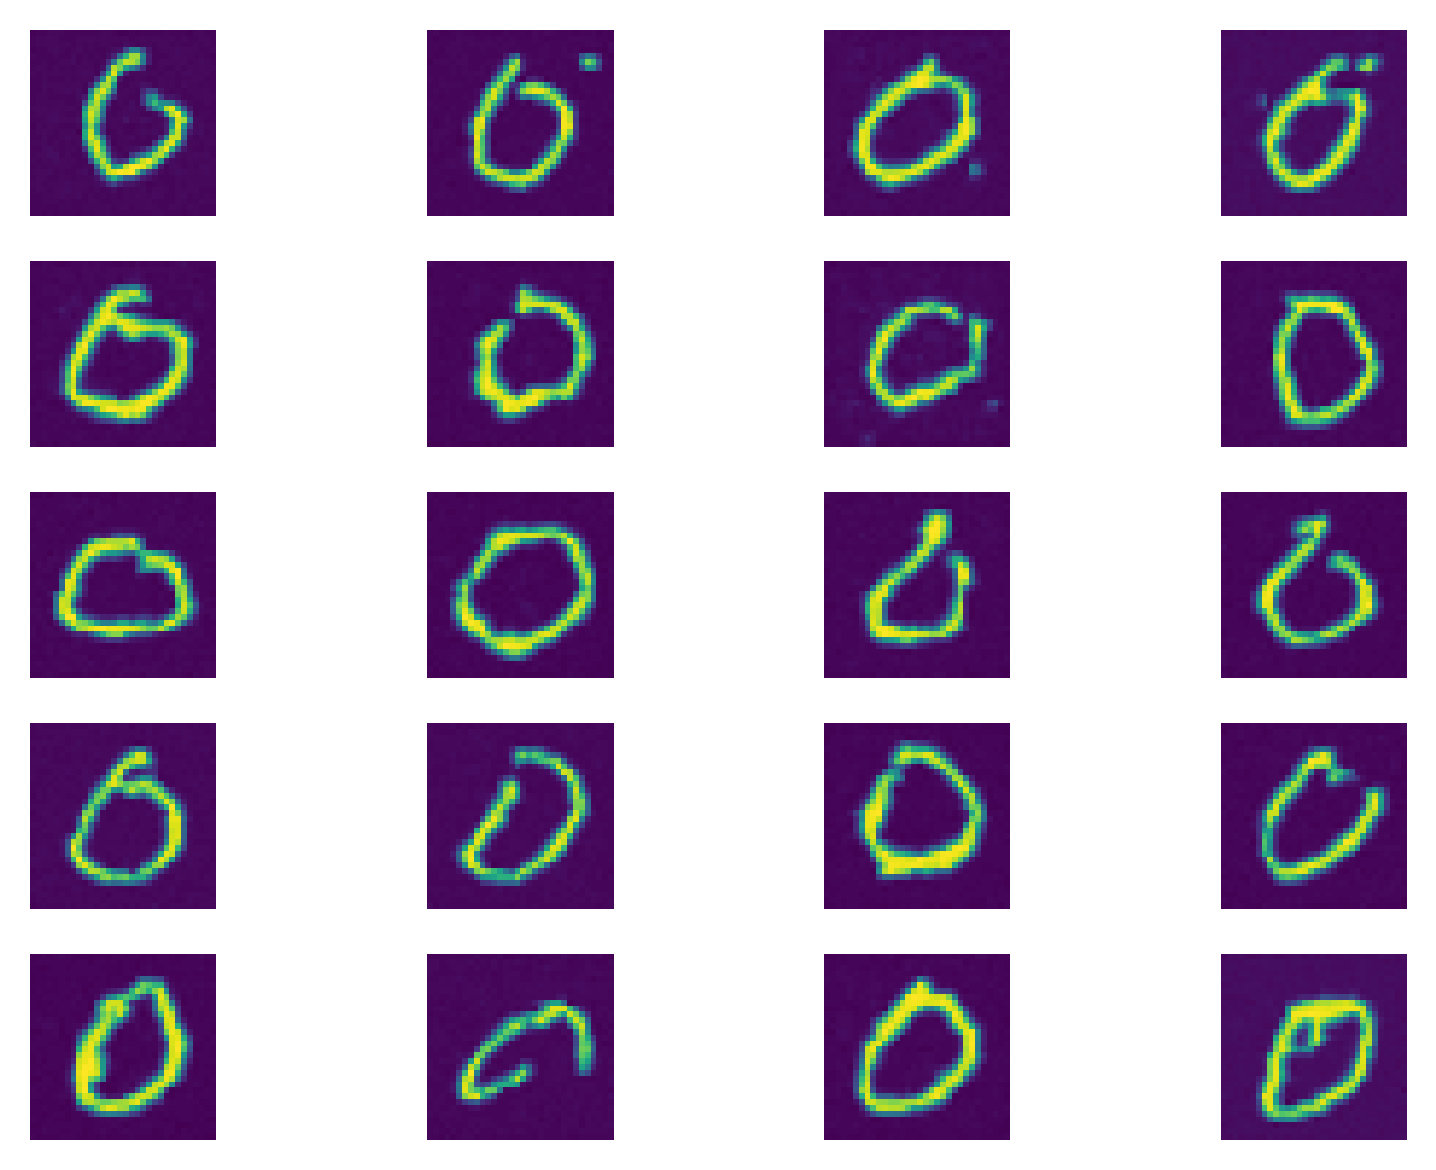

In [45]:
hf.plot_random_samples(args, x_cond_0)
plt.savefig('./output/figures/MNIST_LatentCond_Class0.png', dpi = 300)

#### Generate 1-cond samples: 

In [48]:
x_cond_1 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 1
)



999it [00:59, 16.66it/s]


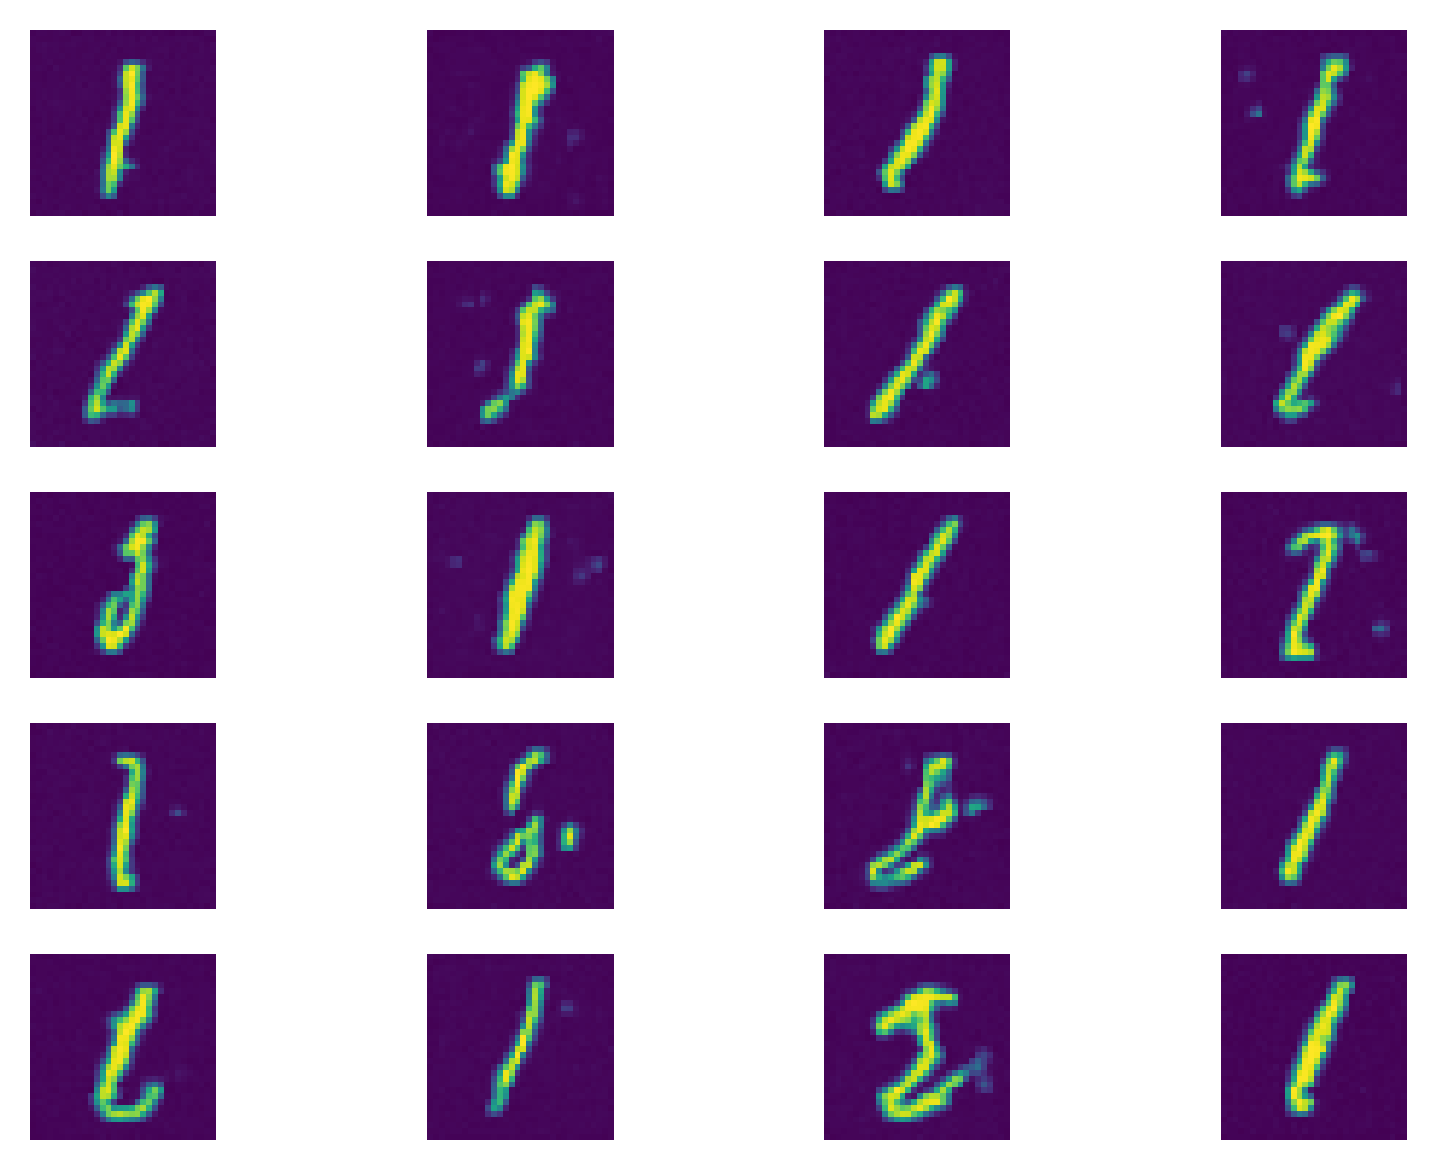

In [49]:
hf.plot_random_samples(args, x_cond_1)
plt.savefig('./output/figures/MNIST_LatentCond_Class1.png', dpi = 300)

#### Generate 2-cond samples: 

In [50]:
x_cond_2 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 2
)


999it [01:01, 16.14it/s]


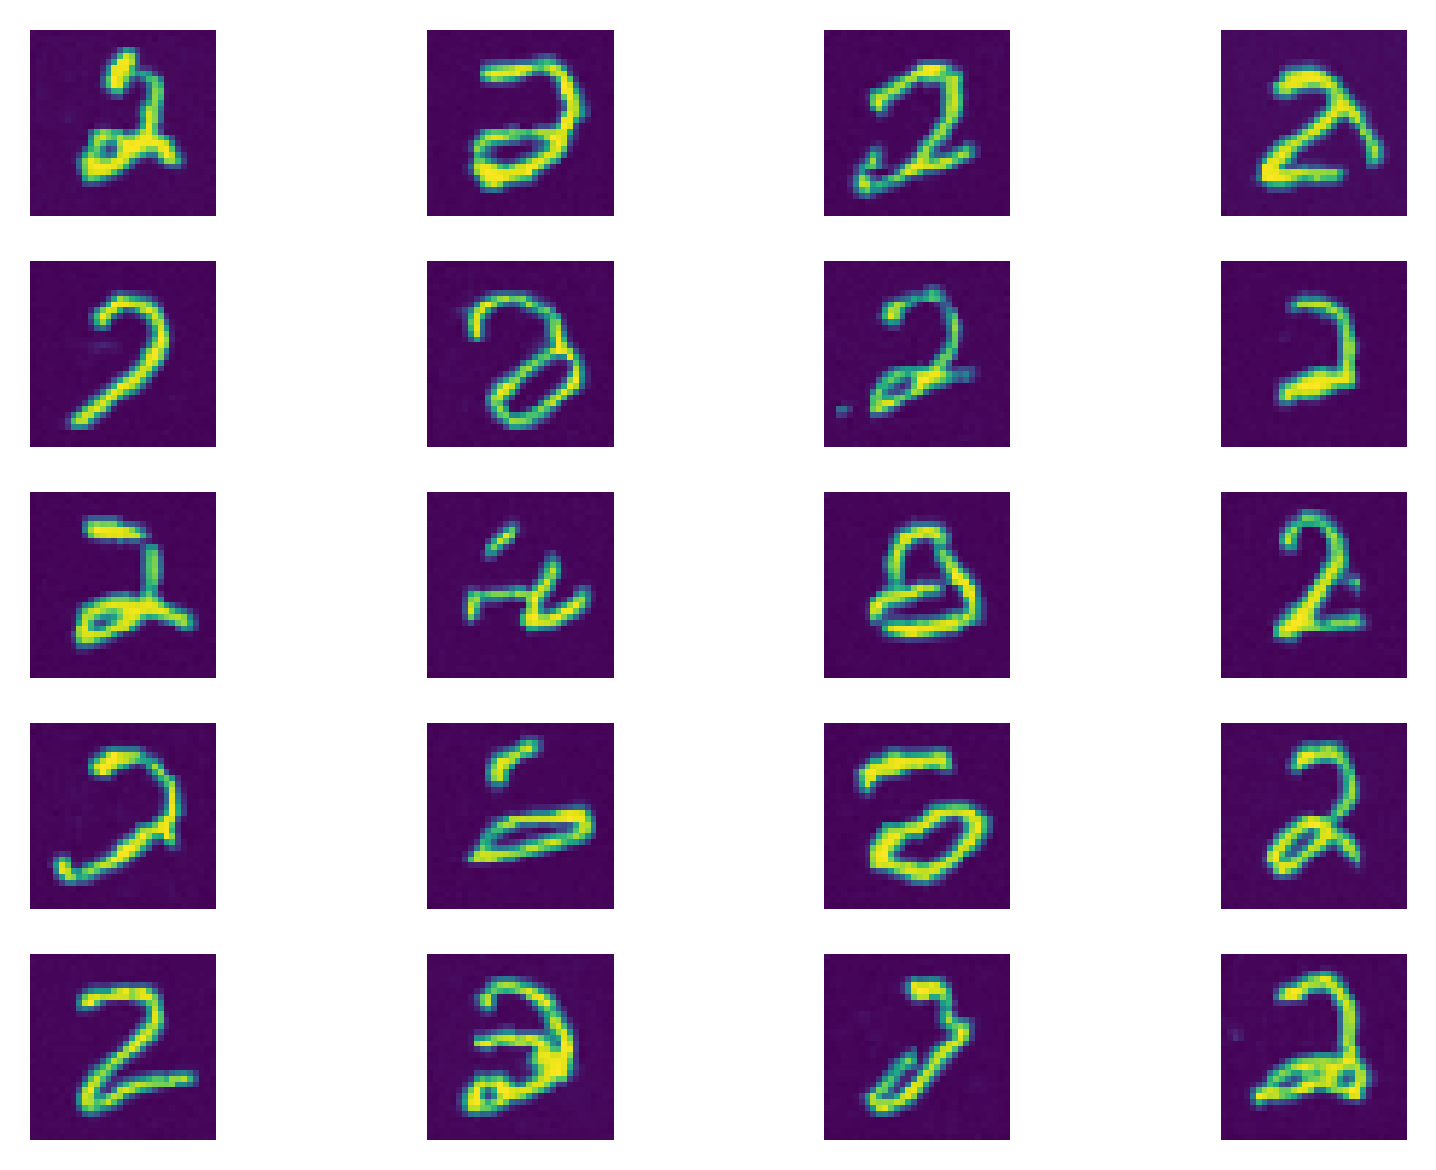

In [51]:
hf.plot_random_samples(args, x_cond_2)
plt.savefig('./output/figures/MNIST_LatentCond_Class2.png', dpi = 300)

#### Generate 3-cond samples: 

In [52]:
x_cond_3 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 3
)


999it [01:02, 15.90it/s]


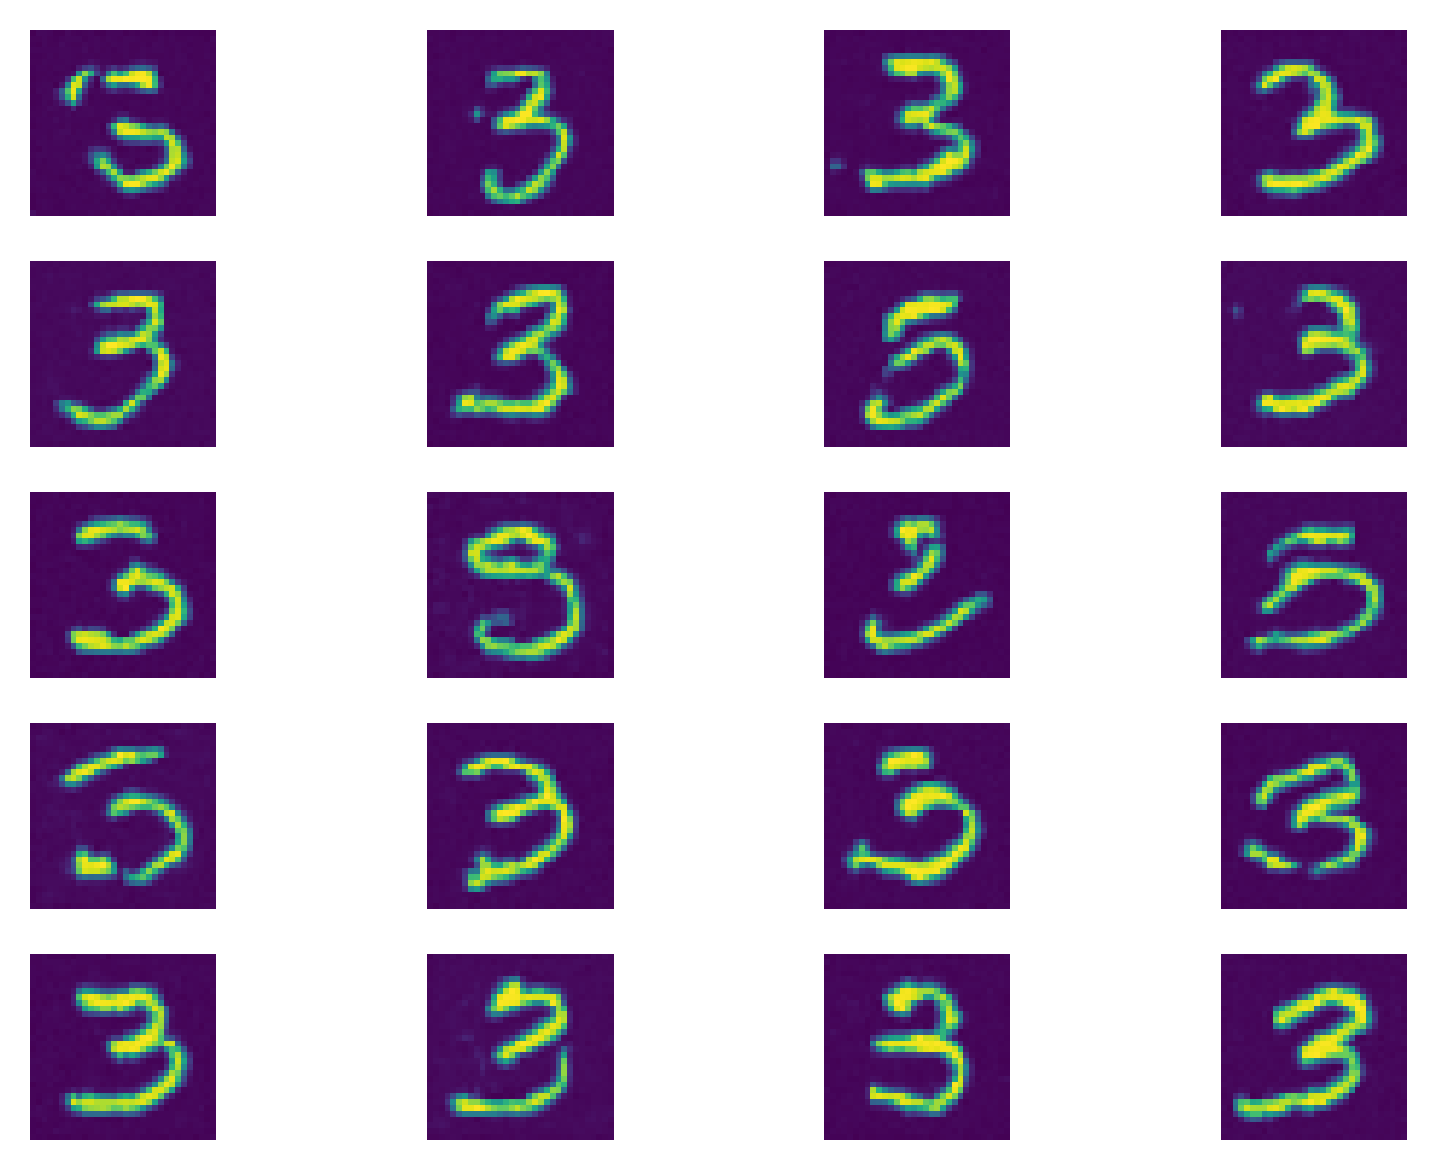

In [53]:
hf.plot_random_samples(args, x_cond_3)
plt.savefig('./output/figures/MNIST_LatentCond_Class3.png', dpi = 300)

#### Generate 4-cond samples: 

In [54]:
x_cond_4 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 4
)


999it [01:03, 15.81it/s]


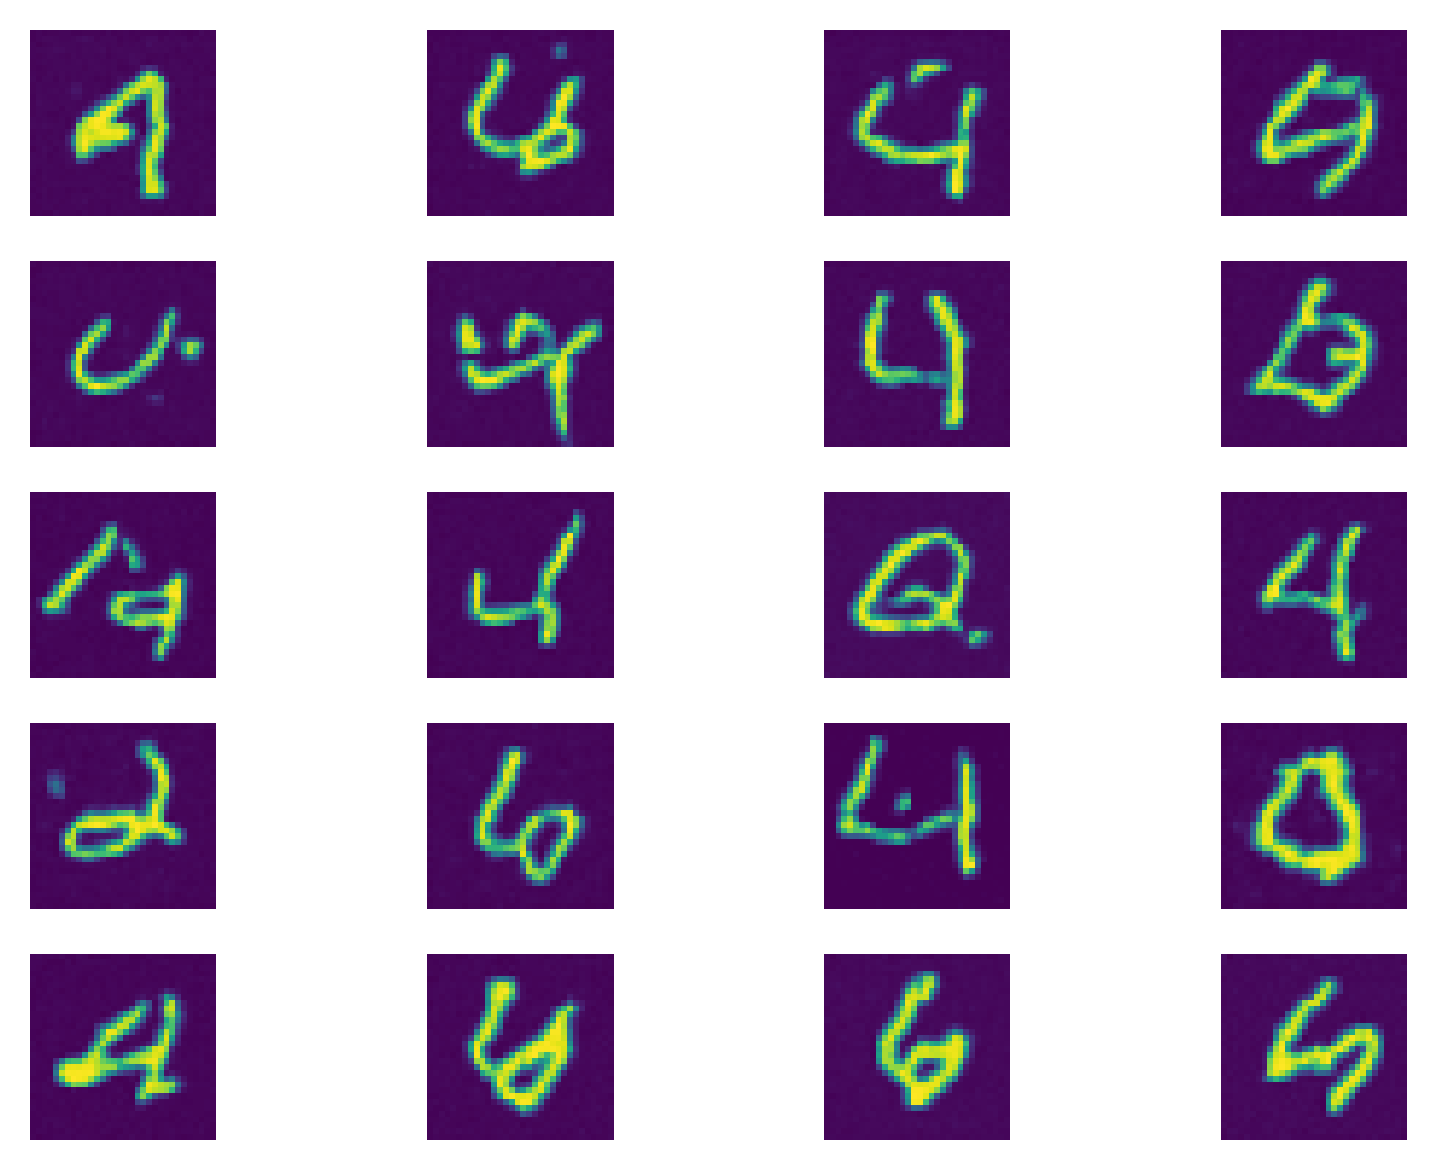

In [55]:
hf.plot_random_samples(args, x_cond_4)
plt.savefig('./output/figures/MNIST_LatentCond_Class4.png', dpi = 300)

#### Generate 5-cond samples: 

In [56]:
x_cond_5 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 5
)


999it [01:02, 15.89it/s]


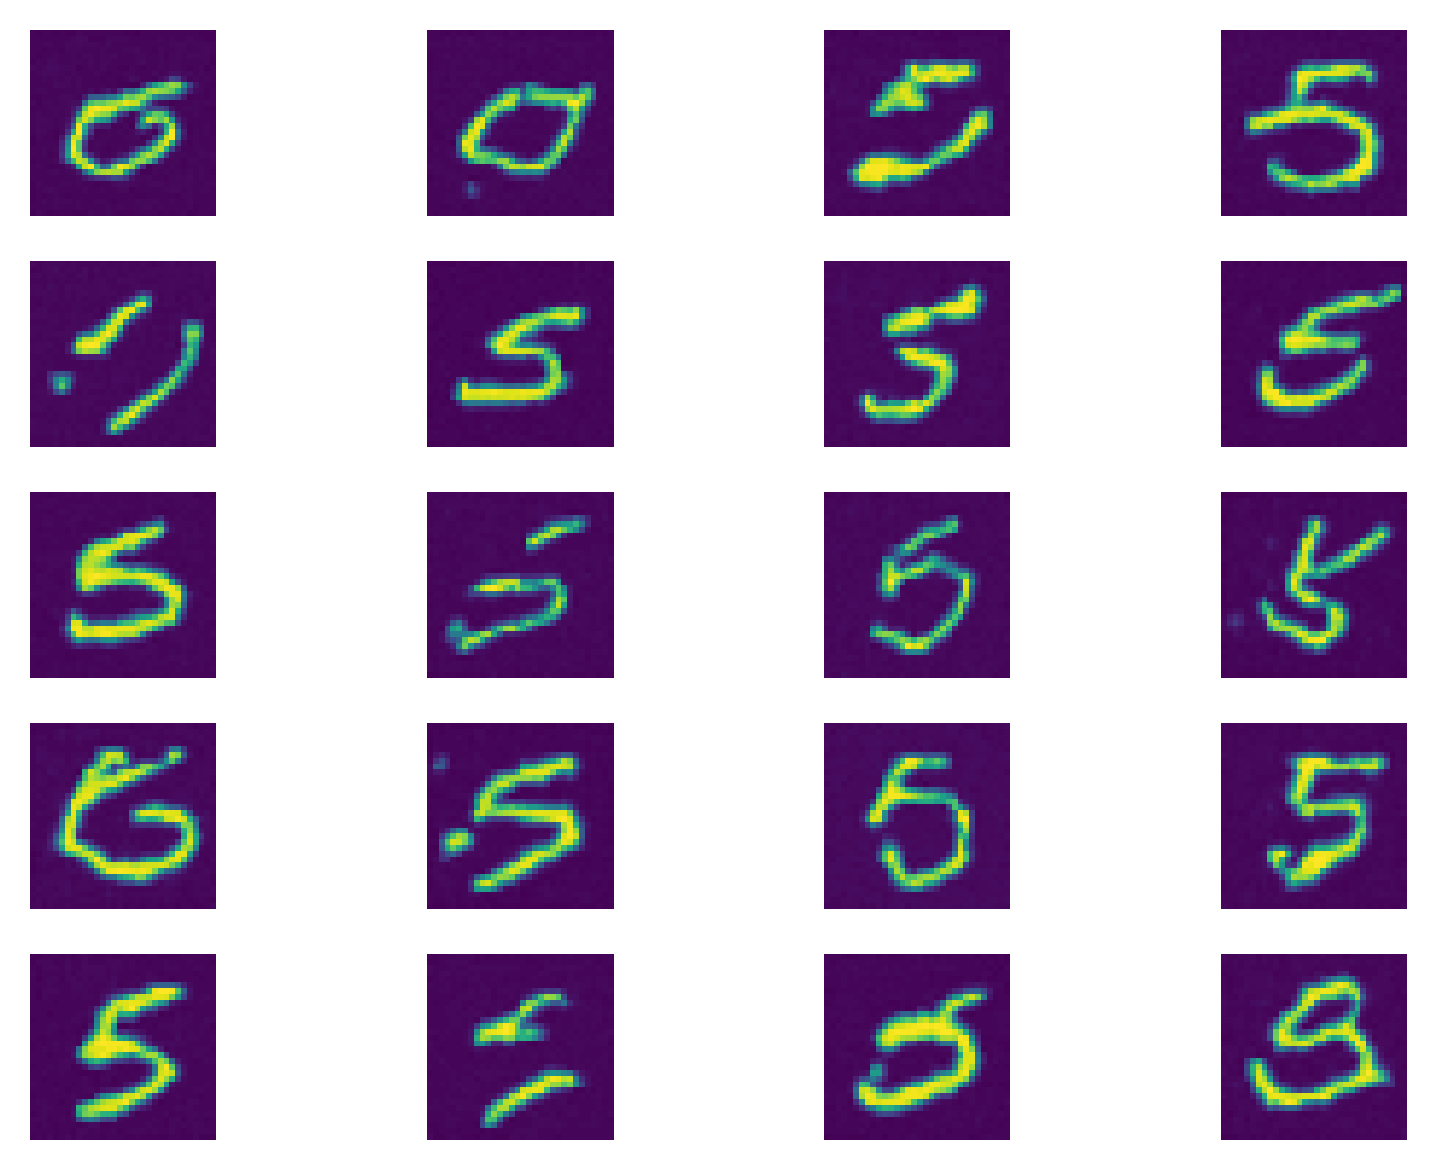

In [57]:
hf.plot_random_samples(args, x_cond_5)
plt.savefig('./output/figures/MNIST_LatentCond_Class5.png', dpi = 300)

#### Generate 6-cond samples: 

In [58]:
x_cond_6 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 6
)


999it [01:03, 15.86it/s]


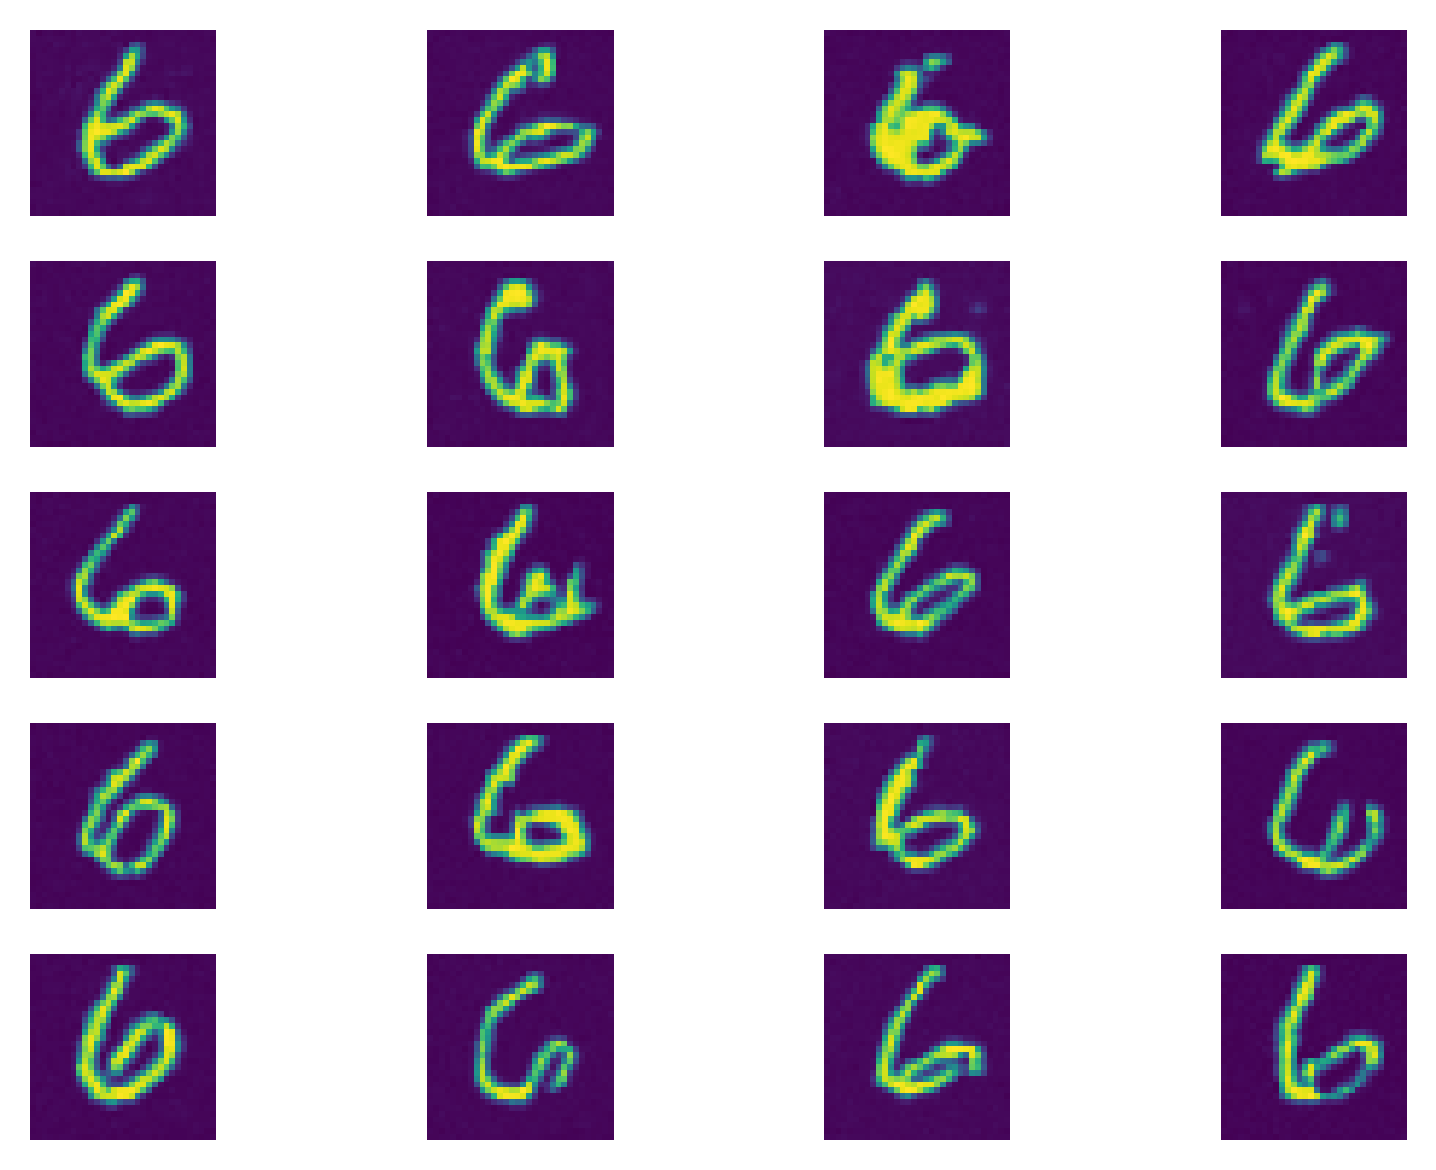

In [59]:
hf.plot_random_samples(args, x_cond_6)
plt.savefig('./output/figures/MNIST_LatentCond_Class6.png', dpi = 300)

#### Generate 7-cond samples: 

In [60]:
x_cond_7 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 7
)



999it [01:02, 15.90it/s]


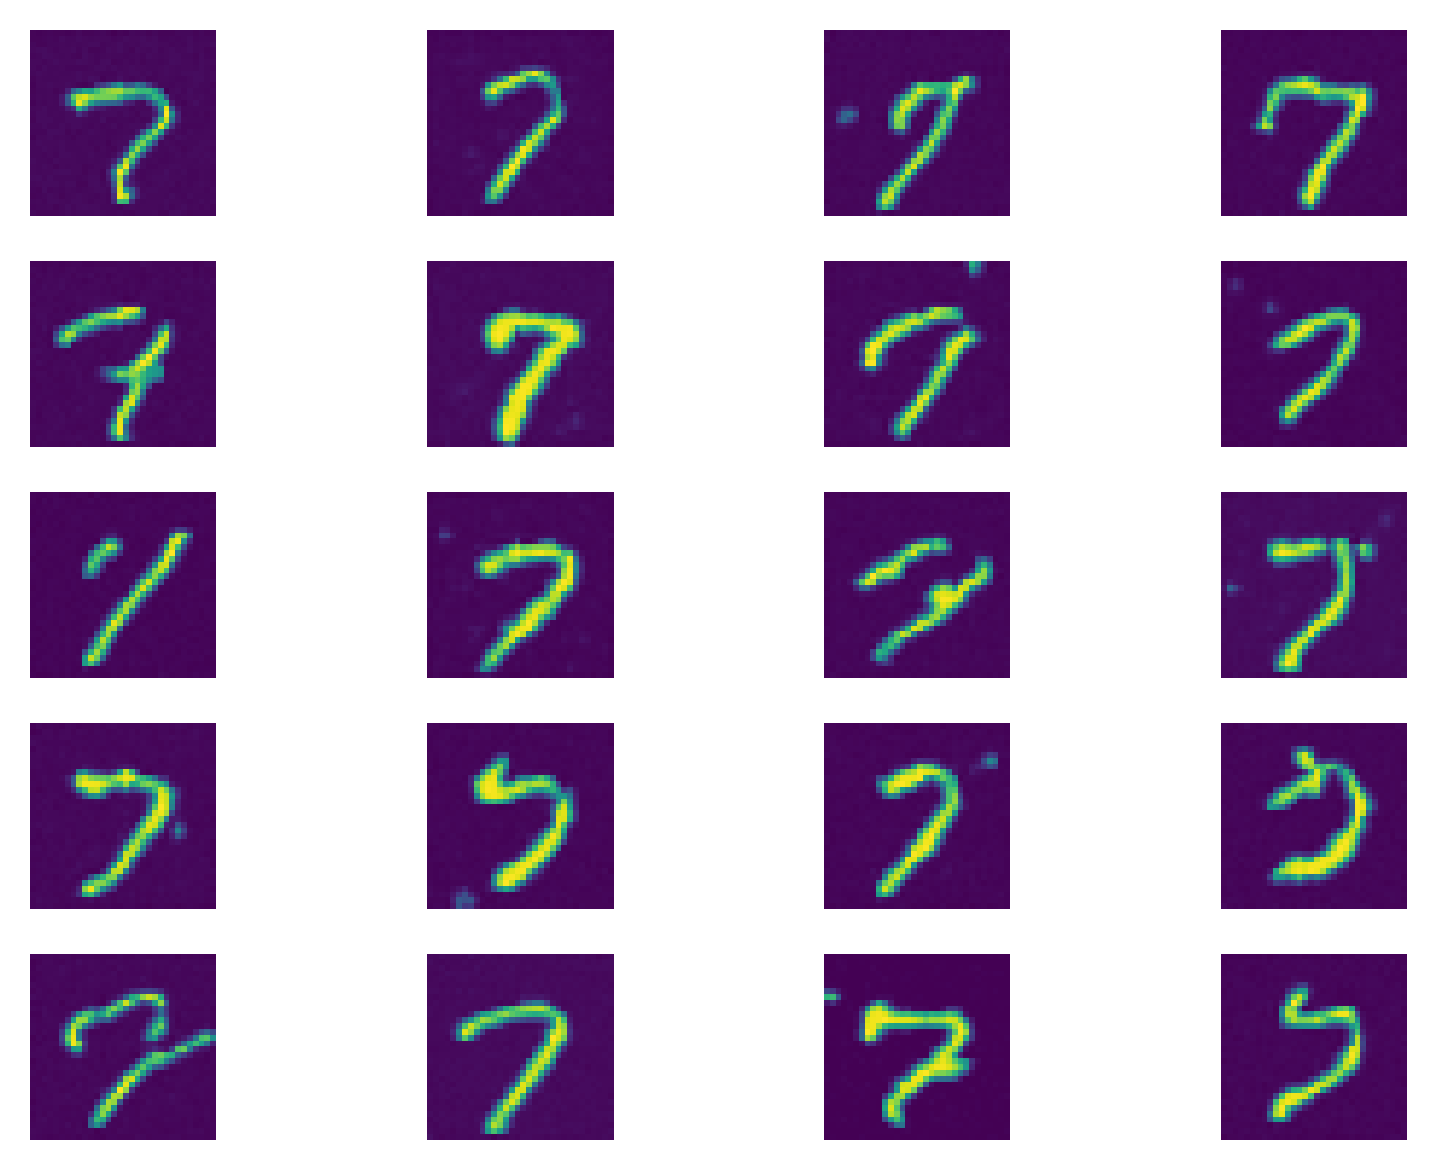

In [61]:
hf.plot_random_samples(args, x_cond_7)
plt.savefig('./output/figures/MNIST_LatentCond_Class7.png', dpi = 300)

#### Generate 8-cond samples: 

In [62]:
x_cond_8 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 8
)


999it [01:02, 15.86it/s]


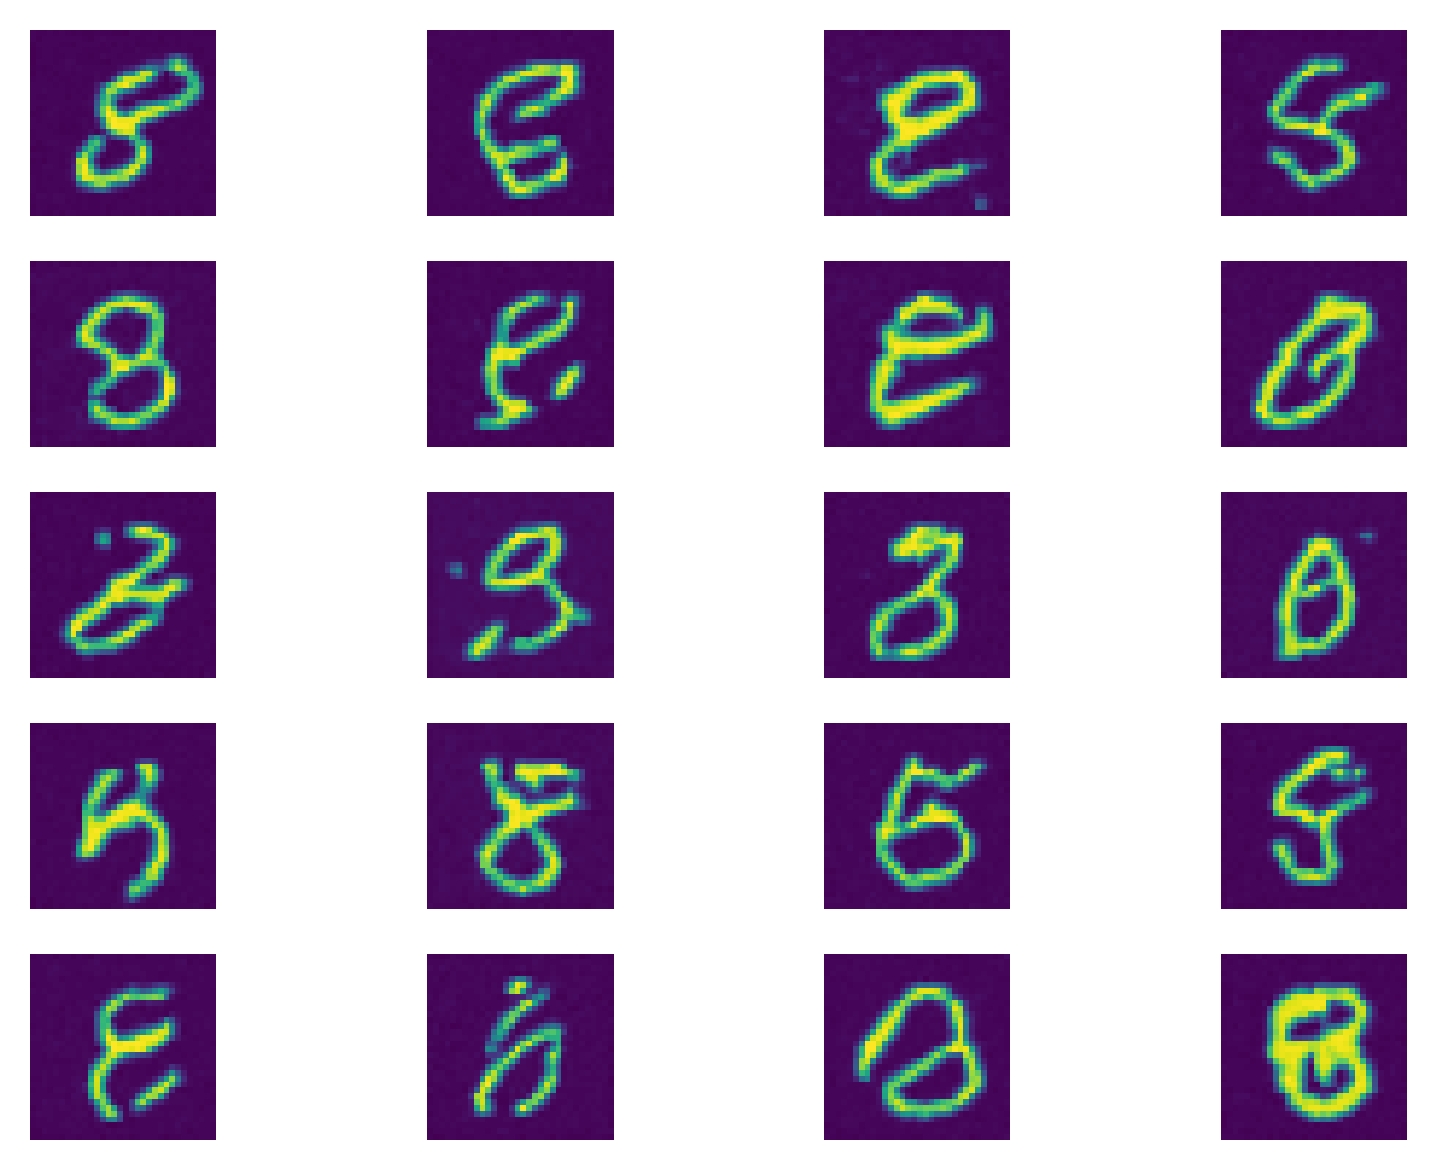

In [63]:
hf.plot_random_samples(args, x_cond_8)
plt.savefig('./output/figures/MNIST_LatentCond_Class8.png', dpi = 300)

#### Generate 9-cond samples: 

In [64]:
x_cond_9 = control_samples(
                DEVICE = DEVICE,
                model = model,
                n = 20,
                z = z_train,
                y = y_train,
                digit = 9
)


999it [01:02, 15.90it/s]


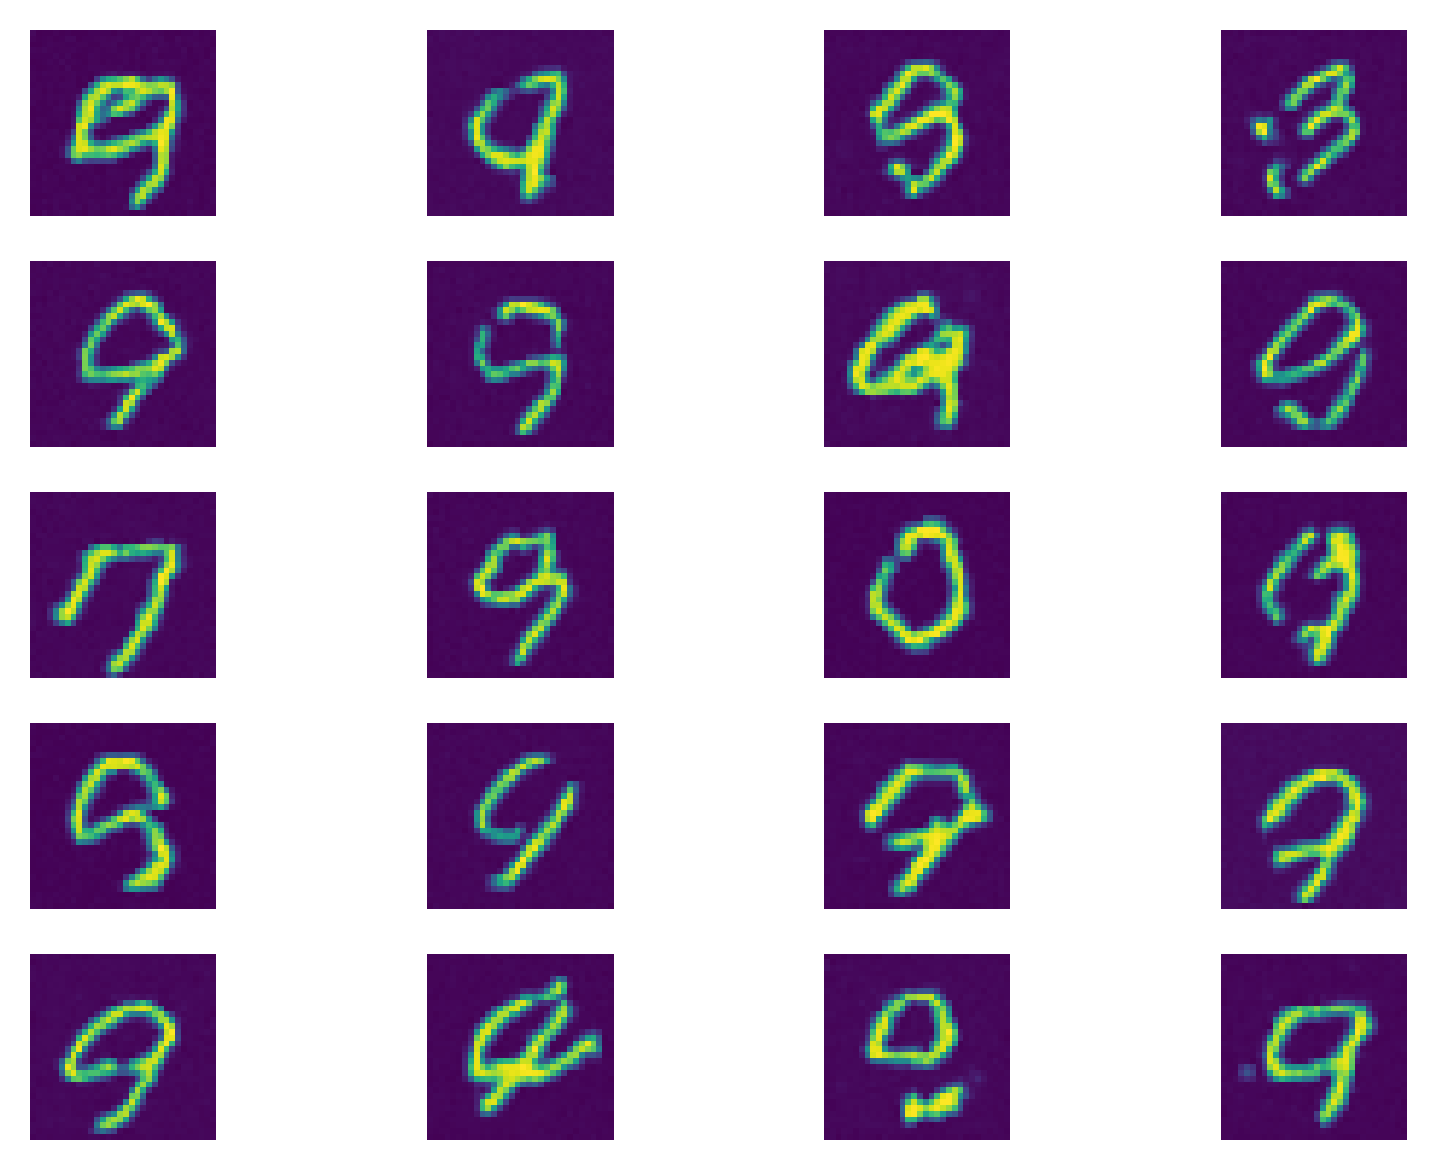

In [65]:
hf.plot_random_samples(args, x_cond_9)
plt.savefig('./output/figures/MNIST_LatentCond_Class9.png', dpi = 300)